In [1]:
! pip install bayesian-optimization
! pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
import folium
import warnings
warnings.filterwarnings("ignore")
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from statsmodels.formula.api import *
from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_validate
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm 
from lightgbm import LGBMRegressor

In [3]:
# load data
data_final = pd.read_csv("data_200k_latest.csv")
data_final = data_final.iloc[:, 1:]
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   week_of_day    200000 non-null  int64  
 1   city           200000 non-null  object 
 2   category       200000 non-null  int64  
 3   county_number  200000 non-null  int64  
 4   county         200000 non-null  object 
 5   item_number    200000 non-null  int64  
 6   bottle_volume  200000 non-null  int64  
 7   cost_price     200000 non-null  float64
 8   retail_price   200000 non-null  float64
 9   volume_sold    200000 non-null  float64
 10  store_number   200000 non-null  int64  
 11  encoded_city   200000 non-null  int64  
 12  population     200000 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 19.8+ MB


In [4]:
data_final.describe()

,week_of_day,category,county_number,item_number,bottle_volume,cost_price,retail_price,volume_sold,store_number,encoded_city,population
count,200000.000000,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2.623875,1.045271e+06,56.594535,45875.595710,944.058925,1.252586,2.697524,7.007196,3636.521410,190.061615,146392.600520
std,1.253911,5.849692e+04,27.615199,50060.734983,456.251818,1.511722,2.726469,6.080006,959.062127,132.999300,159025.023885
min,1.000000,1.011100e+06,1.000000,102.000000,20.000000,0.010000,0.010000,0.020000,2106.000000,0.000000,3645.000000
25%,2.000000,1.012300e+06,31.000000,27780.000000,750.000000,0.370000,0.610000,2.000000,2616.000000,76.000000,21018.000000
50%,3.000000,1.031200e+06,60.000000,38176.000000,750.000000,0.660000,1.400000,6.000000,3747.000000,141.000000,93871.000000
75%,4.000000,1.062310e+06,77.000000,59037.000000,1000.000000,1.030000,4.250000,10.500000,4376.000000,302.000000,215462.000000
max,6.000000,1.901200e+06,99.000000,995545.000000,6000.000000,6.610000,12.500000,36.000000,9919.000000,445.000000,487204.000000


In [5]:
# convert data types 
data_final["city"] = data_final["city"].astype("category")
data_final["category"] = data_final["category"].astype("category")
data_final["county_number"] = data_final["county_number"].astype("category")
data_final["item_number"] = data_final["item_number"].astype("category")
data_final["store_number"] = data_final["store_number"].astype("category")
data_final["encoded_city"] = data_final["encoded_city"].astype("category")
data_final.columns

Index(['week_of_day', 'city', 'category', 'county_number', 'county',
       'item_number', 'bottle_volume', 'cost_price', 'retail_price',
       'volume_sold', 'store_number', 'encoded_city', 'population'],
      dtype='object')

In [6]:
# train-test splitting 
X = data_final[['week_of_day', 'bottle_volume', 
                'cost_price', 'retail_price', 'population', 'encoded_city',
                'category', 'county_number', 'store_number', 'item_number']]

y = data_final.volume_sold
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

## Decision Tree

### Baseline performance

In [7]:
dt_model = DecisionTreeRegressor(max_depth=1, random_state= 100)
dt_model.fit(X_train, y_train)
pred = dt_model.predict(X_test)
r2 = r2_score(y_test, pred)
dt_base_r2 = 1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print("Adjusted R2: " + str(dt_base_r2))

Adjusted R2: 0.1980427312868579


### Parameter Tuning

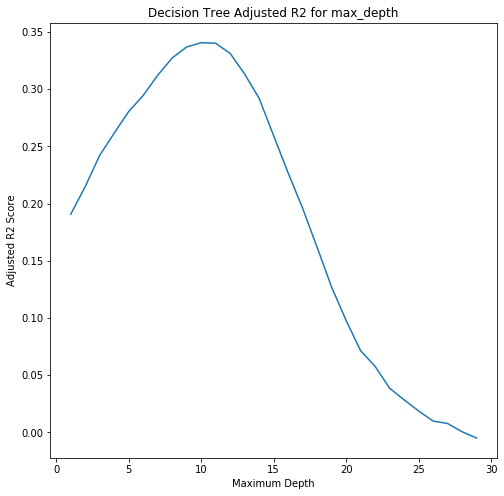

In [8]:
# Cursory search for max_depth hyperparameter
n_estimators_score = []
for i in range(1,30):
    cv_results = cross_validate(DecisionTreeRegressor(max_depth= i, random_state= 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(1,30), n_estimators_score)
plt.title('Decision Tree Adjusted R2 for max_depth')
plt.xlabel('Maximum Depth')
plt.ylabel('Adjusted R2 Score')
plt.show()
fig.savefig('DT-max_depth_new.jpg')
plt.close()

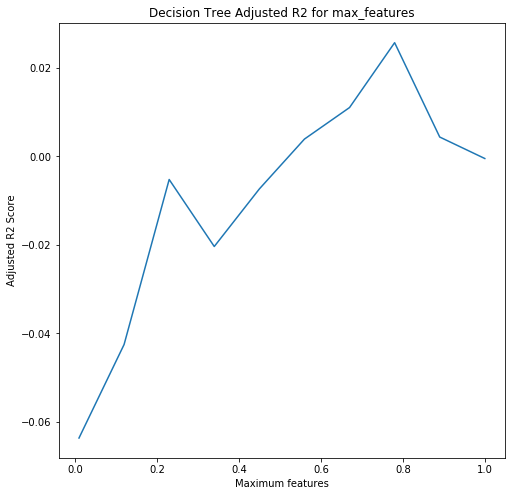

In [9]:
# Cursory search for max_features hyperparameter
n_estimators_score = []
for i in np.linspace(0.1, 1, 10):
    cv_results = cross_validate(DecisionTreeRegressor(max_features= i, random_state= 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(np.linspace(0.01, 1, 10), n_estimators_score)
plt.title('Decision Tree Adjusted R2 for max_features')
plt.xlabel('Maximum features')
plt.ylabel('Adjusted R2 Score')
plt.show()
fig.savefig('DT-max_features_new.jpg')
plt.close()

In [10]:
# Decision Tree regressor tuning 
def dt_func(max_depth,max_features):
    cv_results = cross_validate(DecisionTreeRegressor(max_depth = int(max_depth), 
                                                           max_features = max_features
                                                           ,random_state= 100),
                                X_train, y_train, scoring = 'r2', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])


# Find the global maximum of the target function 
dt_params = BayesianOptimization(dt_func, {'max_depth': (5,15), 'max_features': (0.6, 1)}, random_state = 100)
dt_params.maximize(n_iter = 10, init_points = 2)
final_para_dt = dt_params.max
dt_params.max

|   iter    |  target   | max_depth | max_fe... |
-------------------------------------------------
|  1        |  0.3373   |  10.43    |  0.7113   |
|  2        |  0.3332   |  9.245    |  0.9379   |
|  3        |  0.3029   |  6.716    |  0.6092   |
|  4        |  0.3131   |  13.35    |  1.0      |
|  5        |  0.34     |  11.47    |  1.0      |
|  6        |  0.2575   |  15.0     |  0.6      |
|  7        |  0.2804   |  5.0      |  1.0      |
|  8        |  0.3311   |  11.96    |  0.6      |
|  9        |  0.3405   |  10.44    |  1.0      |
|  10       |  0.3405   |  10.95    |  1.0      |
|  11       |  0.3405   |  10.05    |  1.0      |
|  12       |  0.342    |  11.17    |  0.9954   |


{'target': 0.34195542152267766,
 'params': {'max_depth': 11.167325020936953,
  'max_features': 0.9954376155058846}}

In [11]:
depth = int(final_para_dt['params']['max_depth'])
features = final_para_dt['params']['max_features']

dt_model = DecisionTreeRegressor(max_depth= depth,max_features = features,random_state= 100)
dt_model.fit(X_train, y_train)

pred = dt_model.predict(X_test)
print("max-depth: " + str(depth))
print("max-features: "+str(features))
r2 = r2_score(y_test, pred)
dt_ad_r2 = 1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print("Adjusted R2: " + str(dt_ad_r2))

max-depth: 11
max-features: 0.9954376155058846
Adjusted R2: 0.34625999095142423


In [12]:
features = list(X.columns)
importance = list(dt_model.feature_importances_)
importance_dict = {}
for i in range(len(features)):
    importance_dict[features[i]] = importance[i]
sorted(importance_dict.items(), key = lambda item: abs(item[1]), reverse = True)

[('bottle_volume', 0.53839435901983),
 ('store_number', 0.09793773222027288),
 ('item_number', 0.073941907360397),
 ('cost_price', 0.062444295449990854),
 ('population', 0.06071644094830848),
 ('retail_price', 0.06002240810961856),
 ('category', 0.05763165166663322),
 ('encoded_city', 0.029904319427401363),
 ('county_number', 0.015297360884465382),
 ('week_of_day', 0.0037095249130822392)]

## Random Forest

### Baseline performance

In [13]:
rf_model = RandomForestRegressor(n_estimators = 1, max_depth=1, random_state=100)
rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)
r2 = r2_score(y_test, pred)
rf_base_r2 = 1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print("Adjusted R2: " + str(rf_base_r2))

Adjusted R2: 0.19818997597095867


### Parameter Tuning

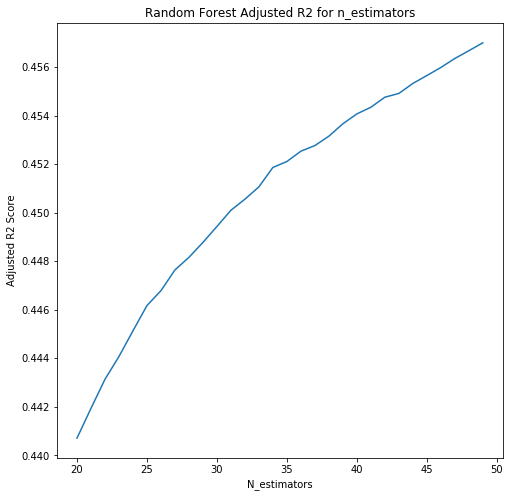

In [14]:
# Cursory search for n_estimators hyperparameter
n_estimators_score = []
for i in range(20,50):
    cv_results = cross_validate(RandomForestRegressor(n_estimators= i,random_state= 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(20,50), n_estimators_score)
plt.title('Random Forest Adjusted R2 for n_estimators')
plt.xlabel('N_estimators')
plt.ylabel('Adjusted R2 Score')
plt.show()
fig.savefig('RF-n_estimators_new.jpg')
plt.close()

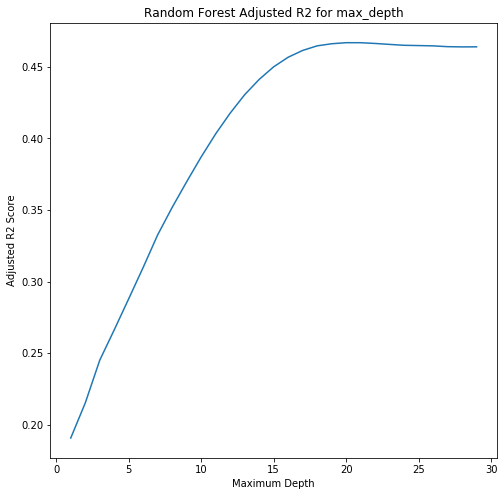

In [15]:
# Cursory search for max_depth hyperparameter
n_estimators_score = []
for i in range(1,30):
    cv_results = cross_validate(RandomForestRegressor(max_depth= i,random_state= 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(1,30), n_estimators_score)
plt.title('Random Forest Adjusted R2 for max_depth')
plt.xlabel('Maximum Depth')
plt.ylabel('Adjusted R2 Score')
plt.show()
fig.savefig('RF-max_depth_new.jpg')
plt.close()

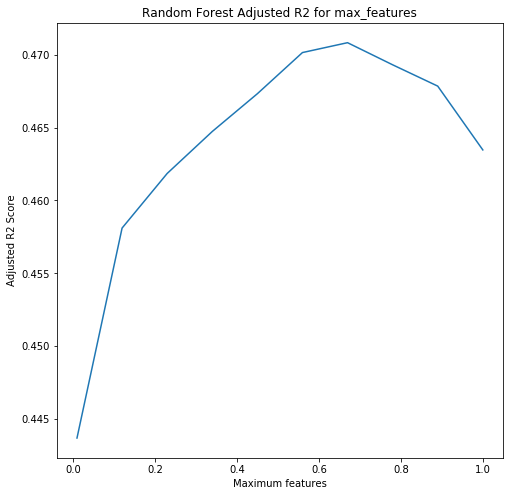

In [16]:
# Cursory search for max_features hyperparameter
n_estimators_score = []
for i in np.linspace(0.1, 1, 10):
    cv_results = cross_validate(RandomForestRegressor(max_features= i,random_state= 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    n_estimators_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(np.linspace(0.01, 1, 10), n_estimators_score)
plt.title('Random Forest Adjusted R2 for max_features')
plt.xlabel('Maximum features')
plt.ylabel('Adjusted R2 Score')
plt.show()
fig.savefig('RF-max_features_new.jpg')
plt.close()

In [17]:
# Random Forest regressor tuning 
def rf_func(n_estimators,max_depth,max_features):
    cv_results = cross_validate(RandomForestRegressor(n_estimators= int(n_estimators),
                                                      max_depth = int(max_depth), 
                                                      max_features = max_features
                                                      ,random_state= 100),
                                X_train, y_train, scoring = 'r2', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])


# Find the global maximum of the target function 
rf_params = BayesianOptimization(rf_func, {'n_estimators': (48,50), 'max_depth': (15,25), 'max_features': (0.4, 1)}, random_state = 100)
rf_params.maximize(n_iter = 10, init_points = 2)
final_para_rf = rf_params.max
rf_params.max

|   iter    |  target   | max_depth | max_fe... | n_esti... |
-------------------------------------------------------------
|  1        |  0.4665   |  20.43    |  0.567    |  48.85    |
|  2        |  0.4627   |  23.45    |  0.4028   |  48.24    |
|  3        |  0.4676   |  20.47    |  0.6322   |  48.89    |
|  4        |  0.4678   |  20.6     |  0.8247   |  49.0     |
|  5        |  0.4626   |  21.02    |  0.4431   |  48.55    |
|  6        |  0.4678   |  20.24    |  0.8648   |  49.03    |
|  7        |  0.4679   |  20.43    |  0.6236   |  49.34    |
|  8        |  0.4631   |  23.92    |  0.4438   |  49.84    |
|  9        |  0.4618   |  20.21    |  1.0      |  49.57    |
|  10       |  0.4641   |  20.74    |  0.4686   |  49.25    |
|  11       |  0.4642   |  20.41    |  0.9458   |  48.76    |
|  12       |  0.4679   |  20.39    |  0.6951   |  49.11    |


{'target': 0.46788596341383365,
 'params': {'max_depth': 20.431696905583763,
  'max_features': 0.6235792490725365,
  'n_estimators': 49.335126645172025}}

In [18]:
estimators = int(final_para_rf['params']['n_estimators'])
depth = int(final_para_rf['params']['max_depth'])
features = final_para_rf['params']['max_features']

rf_model = RandomForestRegressor(n_estimators = estimators,max_depth = depth,max_features = features,random_state= 100)
rf_model.fit(X_train, y_train)

pred = rf_model.predict(X_test)
print("n_estimators: "+str(estimators))
print("max-depth: " + str(depth))
print("max-features: "+str(features))
r2 = r2_score(y_test, pred)
rf_ad_r2 = 1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print("Adjusted R2: " + str(rf_ad_r2))

n_estimators: 49
max-depth: 20
max-features: 0.6235792490725365
Adjusted R2: 0.49218689143708494


In [19]:
features = list(X.columns)
importance = list(rf_model.feature_importances_)
importance_dict = {}
for i in range(len(features)):
    importance_dict[features[i]] = importance[i]
sorted(importance_dict.items(), key = lambda item: abs(item[1]), reverse = True)

[('bottle_volume', 0.25579569457539814),
 ('store_number', 0.1528144949503103),
 ('population', 0.12599017623185857),
 ('item_number', 0.10519953355594108),
 ('retail_price', 0.07582914396090266),
 ('cost_price', 0.07046722356810009),
 ('encoded_city', 0.07033779824759755),
 ('category', 0.05809807563452172),
 ('county_number', 0.04678041212511376),
 ('week_of_day', 0.03868744715025616)]

## Light GBM

### Baseline performance

In [20]:
lgbm_model = LGBMRegressor(max_depth= 1,num_leaves = 2,random_state= 100)
lgbm_model.fit(X_train, y_train)

pred = lgbm_model.predict(X_test)
r2 = r2_score(y_test, pred)
lgbm_base_r2 = 1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print("Adjusted R2: " + str(lgbm_base_r2))

Adjusted R2: 0.37297239521761827


### Parameter Tuning

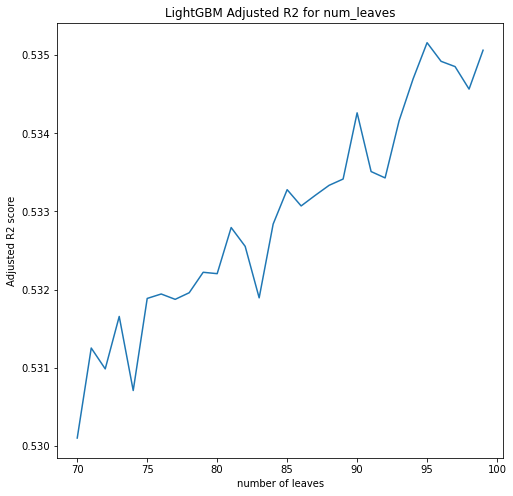

In [21]:
# Cursory search for num_leaves hyperparameter
num_leaves_score = []
for i in range(70,100):
    cv_results = cross_validate(LGBMRegressor(num_leaves= i, random_state = 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    num_leaves_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(70,100), num_leaves_score)
plt.title('LightGBM Adjusted R2 for num_leaves')
plt.xlabel('number of leaves')
plt.ylabel('Adjusted R2 score')
plt.show()
fig.savefig('LGBM-num_leaves_new.jpg')
plt.close()

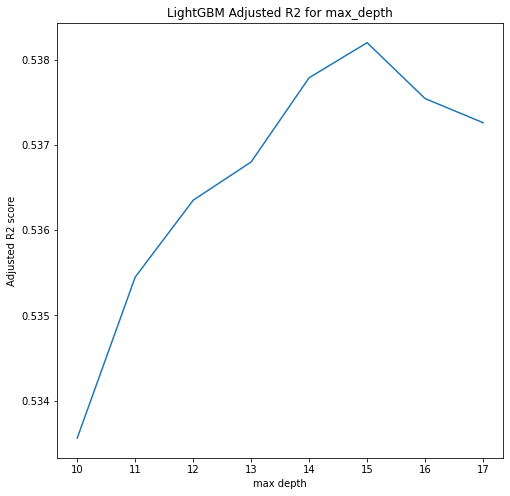

In [22]:
# Cursory search for max_depth hyperparameter
max_depth_score = []
for i in range(10, 20):
    cv_results = cross_validate(LGBMRegressor(max_depth= i, num_leaves = int(pow(2, i)/2), random_state = 100), 
                                X_train, y_train, scoring = 'r2', cv = 3)
    max_depth_score.append(sum(cv_results['test_score']) / len(cv_results['test_score']))
fig, ax = plt.subplots(figsize = (8,8))
plt.plot(range(10,20), max_depth_score)
plt.title('LightGBM Adjusted R2 for max_depth')
plt.xlabel('max depth')
plt.ylabel('Adjusted R2 score')
plt.show()
fig.savefig('LGBM-max_depth_new.jpg')
plt.close()

In [23]:
# LGBM regressor tuning 
def lgbm_func(max_depth,num_leaves):
    cv_results = cross_validate(LGBMRegressor(max_depth = int(max_depth), 
                                              num_leaves = int(num_leaves),
                                              random_state= 100),
                                X_train, y_train, scoring = 'r2', cv = 3)
    return sum(cv_results['test_score']) / len(cv_results['test_score'])


# Find the global maximum of the target function 
lgbm_params = BayesianOptimization(lgbm_func, {'max_depth': (13,17), 'num_leaves': (90, 100)}, random_state = 100)
lgbm_params.maximize(n_iter = 10, init_points = 2)
final_para_lgbm = lgbm_params.max
lgbm_params.max

|   iter    |  target   | max_depth | num_le... |
-------------------------------------------------
|  1        |  0.534    |  15.17    |  92.78    |
|  2        |  0.5344   |  14.7     |  98.45    |
|  3        |  0.5344   |  14.68    |  98.47    |
|  4        |  0.5352   |  17.0     |  100.0    |
|  5        |  0.5353   |  17.0     |  98.65    |
|  6        |  0.5351   |  17.0     |  96.41    |
|  7        |  0.5334   |  13.0     |  90.0     |
|  8        |  0.535    |  17.0     |  94.58    |
|  9        |  0.5342   |  17.0     |  90.0     |
|  10       |  0.535    |  17.0     |  97.88    |
|  11       |  0.5338   |  13.0     |  95.63    |
|  12       |  0.5348   |  15.78    |  100.0    |


{'target': 0.5352683672005202,
 'params': {'max_depth': 17.0, 'num_leaves': 98.65155668717047}}

In [24]:
depth = int(final_para_lgbm['params']['max_depth'])
leaves = int(final_para_lgbm['params']['num_leaves'])

lgbm_model = LGBMRegressor(max_depth= depth,num_leaves = leaves,random_state= 100)
lgbm_model.fit(X_train, y_train)

pred = lgbm_model.predict(X_test)
print("max-depth: " + str(depth))
print("num_leaves: "+str(leaves))
r2 = r2_score(y_test, pred)
lgbm_ad_r2 = 1-(1-r2)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
print("Adjusted R2: " + str(lgbm_ad_r2))

max-depth: 17
num_leaves: 98
Adjusted R2: 0.5476385684178686


In [25]:
features = list(X.columns)
importance = list(lgbm_model.feature_importances_)
importance_dict = {}
for i in range(len(features)):
    importance_dict[features[i]] = importance[i]
importance = sorted(importance_dict.items(), key = lambda item: abs(item[1]), reverse = True)
importance

[('store_number', 2610),
 ('item_number', 2268),
 ('category', 991),
 ('encoded_city', 778),
 ('population', 718),
 ('retail_price', 652),
 ('cost_price', 596),
 ('county_number', 443),
 ('bottle_volume', 396),
 ('week_of_day', 248)]

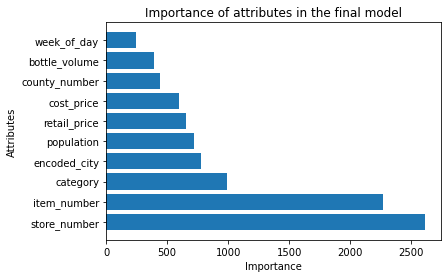

In [28]:
# Importance of attributes
x = []
y = []
for i in range(len(importance)):
    x.append(importance[i][1])
    y.append(importance[i][0])
fig, ax = plt.subplots()
plt.barh(y, x)
plt.xlabel("Importance")
plt.ylabel("Attributes")
plt.title("Importance of attributes in the final model")
fig.savefig('8.Attribute Importance in the Final Model.jpg')
plt.show()

## Result of RMSE

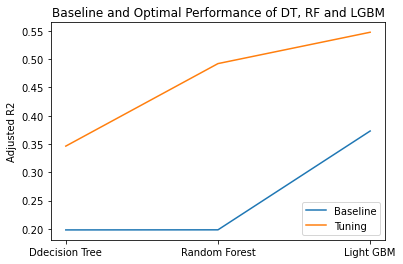

In [29]:
baseline = [dt_base_r2, rf_base_r2, lgbm_base_r2]
tuning = [dt_ad_r2, rf_ad_r2, lgbm_ad_r2]
model = ["Ddecision Tree", "Random Forest", "Light GBM"]
fig, ax = plt.subplots()
plt.title("Baseline and Optimal Performance of DT, RF and LGBM")
plt.ylabel("Adjusted R2")
plt.plot(model, baseline, label = 'Baseline')
plt.plot(model, tuning, label = 'Tuning')
plt.legend(loc = 'lower right')
plt.show()
fig.savefig('7.Adjusted R2 for three models.jpg')